In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load DataFrame and Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [3]:
# Train-test split

train_size = int(len(df) * 0.8) 

train_df,test_df = df[1:train_size], df[train_size:] 

In [4]:
test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [5]:
# Scaling

train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [6]:
# Now we will make a function that will use a sliding window approach to transform our series into samples 
# of input past observations and output future observations to use supervised learning algorithms.

# FUNCTION
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [7]:
# Convert train and test data:

# Variables
n_past = 60
n_future = 136
n_features = 6

# CALLS
X_train, y_train = split_series(train.values, n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [8]:
X_train.shape

(604, 60, 6)

In [9]:
X_test.shape

(5, 60, 6)

In [10]:
y_train.shape

(604, 136, 6)

In [11]:
y_test.shape

(5, 136, 6)

# Multivariate model

In [12]:
# Doesn't work like this but technically its the same as the stuff below (?) -- For simplicity look at this

# Sequence to Sequence Model with one encoder and one decoder layer.

Epoch 1/250
3/3 [==============================] - 2s 546ms/step - loss: 0.1828 - val_loss: 0.2349
Epoch 2/250
3/3 [==============================] - 1s 254ms/step - loss: 0.1820 - val_loss: 0.2341
Epoch 3/250
3/3 [==============================] - 1s 251ms/step - loss: 0.1812 - val_loss: 0.2337
Epoch 4/250
3/3 [==============================] - 1s 248ms/step - loss: 0.1808 - val_loss: 0.2328
Epoch 5/250
3/3 [==============================] - 1s 268ms/step - loss: 0.1801 - val_loss: 0.2321
Epoch 6/250
3/3 [==============================] - 1s 259ms/step - loss: 0.1795 - val_loss: 0.2312
Epoch 7/250
3/3 [==============================] - 1s 240ms/step - loss: 0.1786 - val_loss: 0.2296
Epoch 8/250
3/3 [==============================] - 1s 272ms/step - loss: 0.1773 - val_loss: 0.2273
Epoch 9/250
3/3 [==============================] - 1s 233ms/step - loss: 0.1750 - val_loss: 0.2230
Epoch 10/250
3/3 [==============================] - 1s 266ms/step - loss: 0.1708 - val_loss: 0.2104
Epoch 11/

3/3 [==============================] - 1s 294ms/step - loss: 0.0048 - val_loss: 0.0254
Epoch 84/250
3/3 [==============================] - 1s 287ms/step - loss: 0.0047 - val_loss: 0.0238
Epoch 85/250
3/3 [==============================] - 1s 284ms/step - loss: 0.0045 - val_loss: 0.0224
Epoch 86/250
3/3 [==============================] - 1s 282ms/step - loss: 0.0043 - val_loss: 0.0212
Epoch 87/250
3/3 [==============================] - 1s 300ms/step - loss: 0.0044 - val_loss: 0.0197
Epoch 88/250
3/3 [==============================] - 1s 305ms/step - loss: 0.0038 - val_loss: 0.0190
Epoch 89/250
3/3 [==============================] - 1s 300ms/step - loss: 0.0043 - val_loss: 0.0150
Epoch 90/250
3/3 [==============================] - 1s 328ms/step - loss: 0.0031 - val_loss: 0.0128
Epoch 91/250
3/3 [==============================] - 1s 326ms/step - loss: 0.0029 - val_loss: 0.0120
Epoch 92/250
3/3 [==============================] - 1s 339ms/step - loss: 0.0026 - val_loss: 0.0114
Epoch 93/250


3/3 [==============================] - 1s 336ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 246/250
3/3 [==============================] - 1s 336ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 247/250
3/3 [==============================] - 1s 459ms/step - loss: 0.0013 - val_loss: 0.0089
Epoch 248/250
3/3 [==============================] - 1s 427ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 249/250
3/3 [==============================] - 1s 403ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 250/250
3/3 [==============================] - 1s 410ms/step - loss: 0.0011 - val_loss: 0.0076


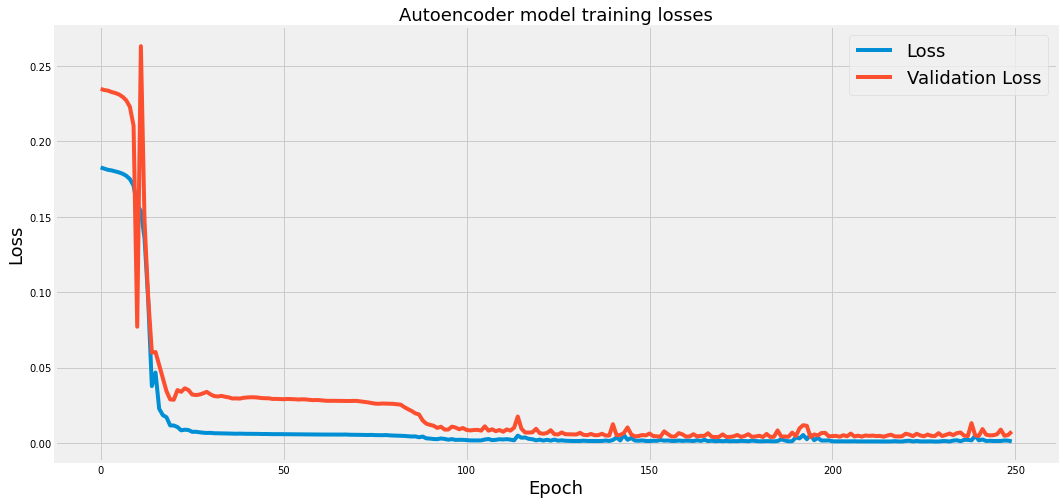

Wall time: 6min 52s


In [13]:
%%time

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(128, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.Huber())

history = model.fit(
                    X_train, y_train, 
                    batch_size=256, 
                    epochs=250, 
                    validation_data=(X_test,y_test)
                   )

# Plot Training Loss
plt.figure(figsize=(16,8))
plt.plot(history.history['loss']) # add validation loss
plt.plot(history.history['val_loss']) # add validation loss
plt.title('Autoencoder model training losses', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.legend(['Loss','Validation Loss'], loc='upper right', fontsize=18)
plt.show()

In [14]:
pred = model.predict(X_test)
pred.shape

(5, 136, 6)

In [15]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred[:,:,index]=scaler.inverse_transform(pred[:,:,index])
    #y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
y_test.shape

(5, 136, 6)

Pred vs test of Feature 0 (x):

In [16]:
y_test[0,:,0]

array([ 36469.11006238,  29881.87362072,  19126.08641357,   5668.28662176,
        -8580.68636836, -21580.77033154, -31508.40559114, -37025.09594659,
       -37423.65401184, -32679.21080377, -23442.55060601, -10978.72035769,
         2985.7054782 ,  16520.84509467,  27798.55840532,  35344.6529504 ,
        38188.59658665,  35937.84933107,  28822.74069404,  17720.63777403,
         4114.25199323, -10076.80861617, -22801.97239595, -32242.02806097,
       -37102.74134816, -36769.24757745, -31336.97455908, -21571.53138319,
        -8818.30767242,   5160.81489587,  18443.01905644,  29245.27551094,
        36173.05174199,  38358.08582002,  35508.90974646,  27930.06425218,
        16532.92597256,   2803.99330865, -11337.25085958, -23827.15132184,
       -32834.79545718, -37090.67245283, -36060.64730559, -29961.60688874,
       -19682.2591247 ,  -6654.86141998,   7325.09001583,  20349.69801356,
        30687.39019716,  37022.46297369,  38582.7040899 ,  35170.55413207,
        27159.65660567,  

In [17]:
pred[0,:,0]

array([ 3.8770828e+04,  3.1287916e+04,  1.9748990e+04,  5.6890435e+03,
       -8.9388857e+03, -2.1989885e+04, -3.1548051e+04, -3.6353629e+04,
       -3.5980852e+04, -3.0674500e+04, -2.1085311e+04, -8.2622070e+03,
        6.1500171e+03,  1.9939035e+04,  3.0861789e+04,  3.7362785e+04,
        3.8868574e+04,  3.5544902e+04,  2.7886160e+04,  1.6608066e+04,
        2.9249622e+03, -1.1314255e+04, -2.3949299e+04, -3.3045977e+04,
       -3.7345727e+04, -3.6441707e+04, -3.0615787e+04, -2.0584703e+04,
       -7.4886367e+03,  6.9558008e+03,  2.0536078e+04,  3.1087785e+04,
        3.7163738e+04,  3.8270930e+04,  3.4606867e+04,  2.6670410e+04,
        1.5201098e+04,  1.4680574e+03, -1.2634285e+04, -2.4945119e+04,
       -3.3579359e+04, -3.7358539e+04, -3.5951566e+04, -2.9688301e+04,
       -1.9321586e+04, -6.0420991e+03,  8.3766230e+03,  2.1702844e+04,
        3.1824596e+04,  3.7392453e+04,  3.7999207e+04,  3.3885016e+04,
        2.5565961e+04,  1.3820230e+04, -1.6887547e+01, -1.4004438e+04,
      

## Visualizations:

In [18]:
dictt = {
    0: "x",
    1: "y",
    2: 'z',
    3: 'x_velocity',
    4: 'y_velocity',
    5: 'z_velocity',
}

0


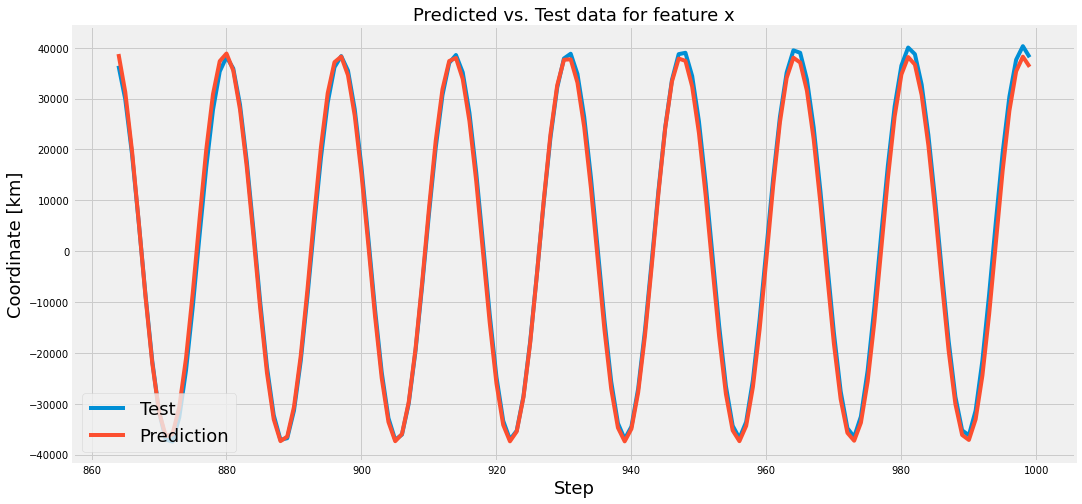

1


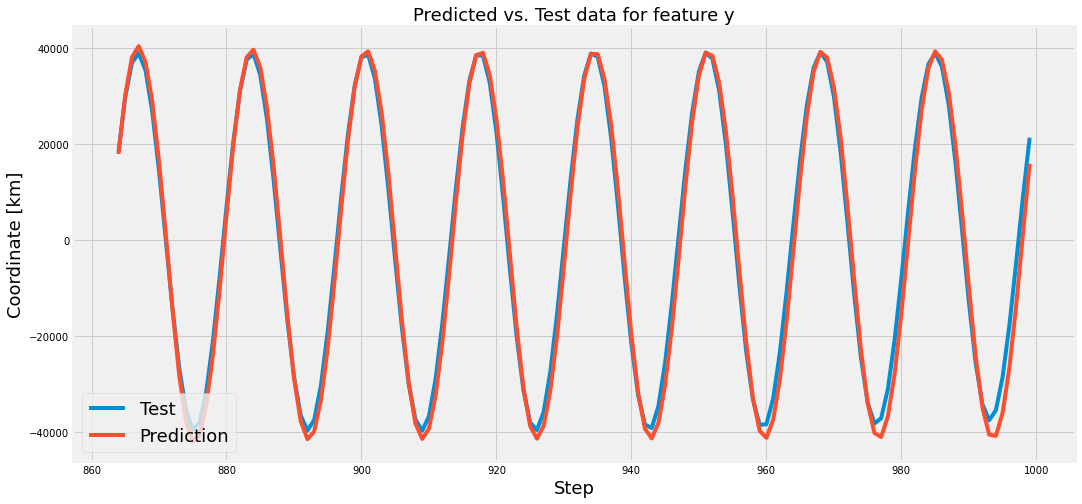

2


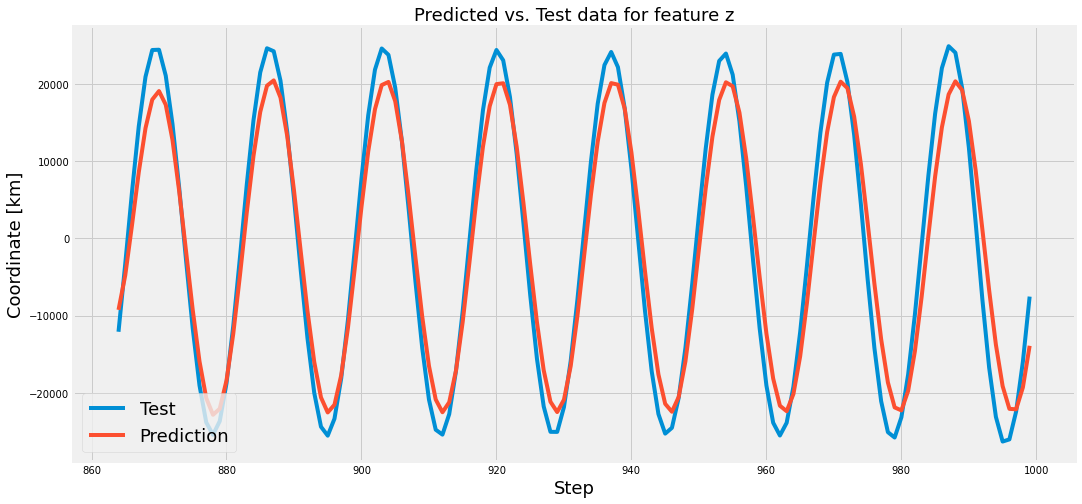

3


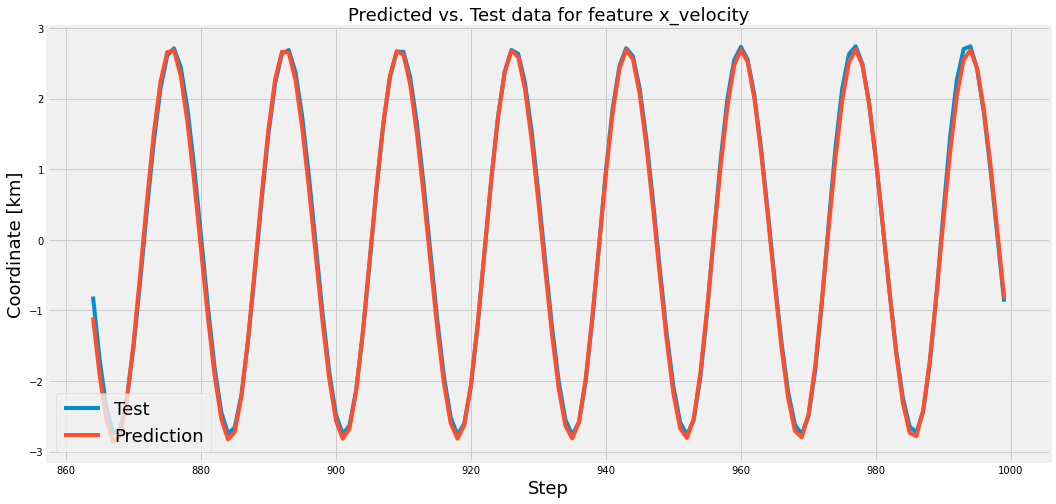

4


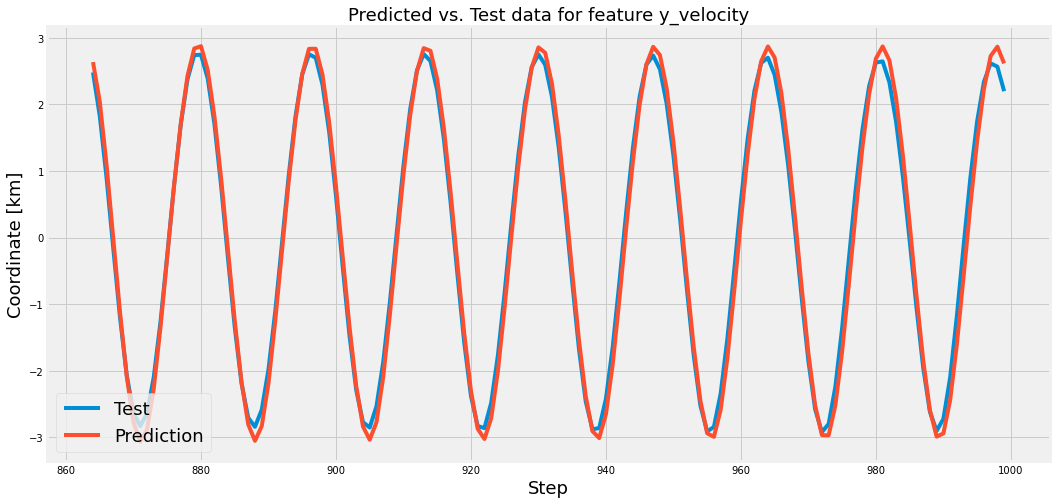

5


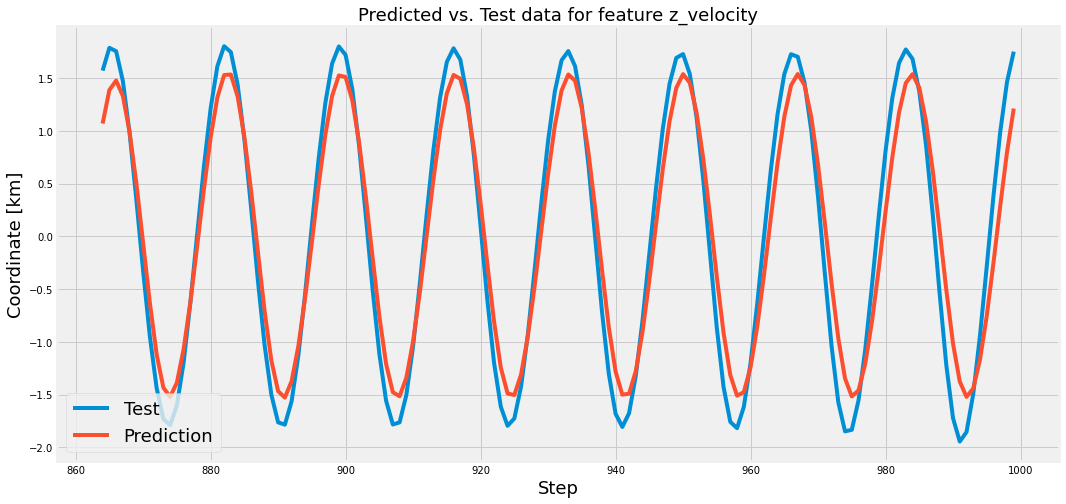

In [31]:
for i in range(0,6):
    print(i)
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    plt.figure(figsize=(16,8))
    plt.title(f'Predicted vs. Test data for feature {dictt[i]}', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Coordinate [km]', fontsize=18)
    plt.plot(list(range(864,1000)), dff.testY)
    plt.plot(list(range(864,1000)), dff.predictions)
    plt.legend(['Test', 'Prediction'], loc='lower left', fontsize=18)
    plt.show()

## RMSE:

In [20]:
# RMSE CORRECT Formula

print('RMSE for Features 0-5:')
print()
for i in range(0,6):
    rmse = np.sqrt(np.mean(((pred[0,:,i] - y_test[0,:,i]) ** 2))) #3rd var is index/feature no
    print(rmse)

RMSE for Features 0-5:

1642.0556999162272
3125.772222393553
4324.546338863684
0.09308088344212216
0.19338109035790108
0.3236547518663225


In [21]:
# RMSE CORRECT Formula

print('RMSE for Features 0-5:')
print()
for i in range(0,6):
    rmse = np.sqrt(mean_squared_error(y_test[0,:,i], pred[0,:,i]))
    print(rmse)

RMSE for Features 0-5:

1642.0556999162272
3125.772222393553
4324.546338863684
0.09308088344212216
0.19338109035790108
0.3236547518663225


RMSE is not a step-by-step error, just the mean. So it's only 1 value per test per feature.

## Errors:

### 1. Absolute errors:

0


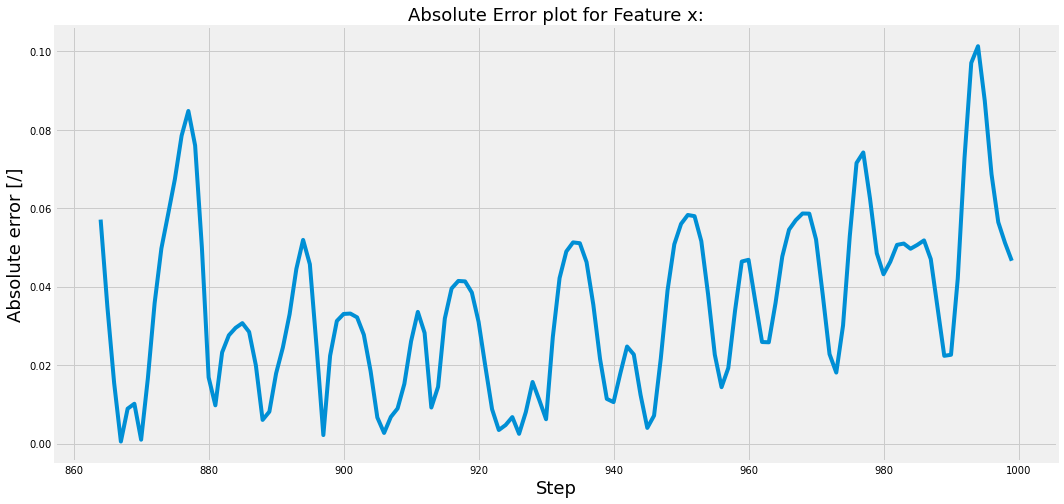

1


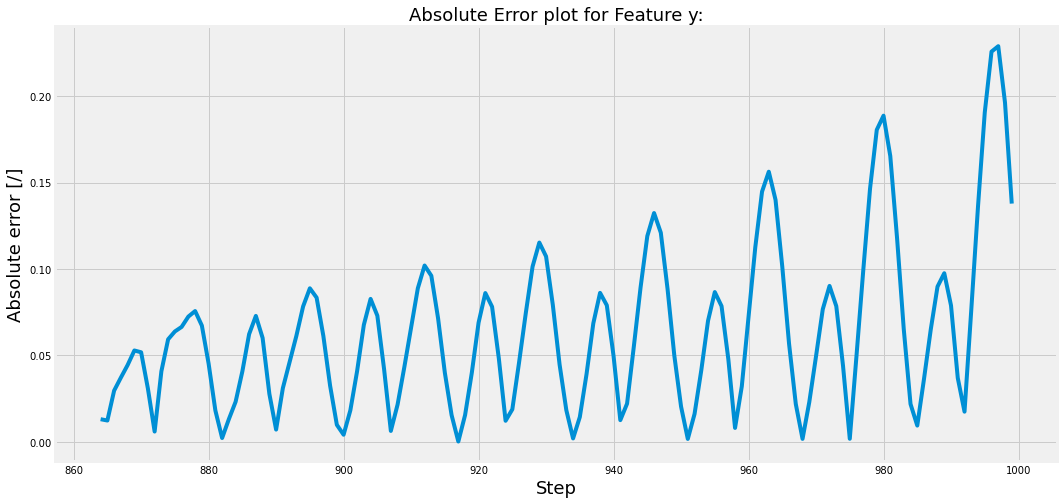

2


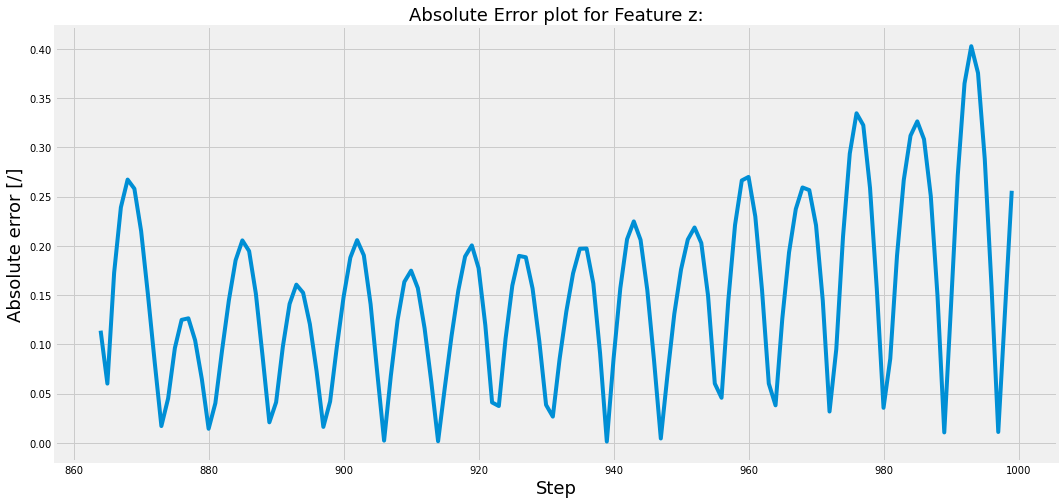

3


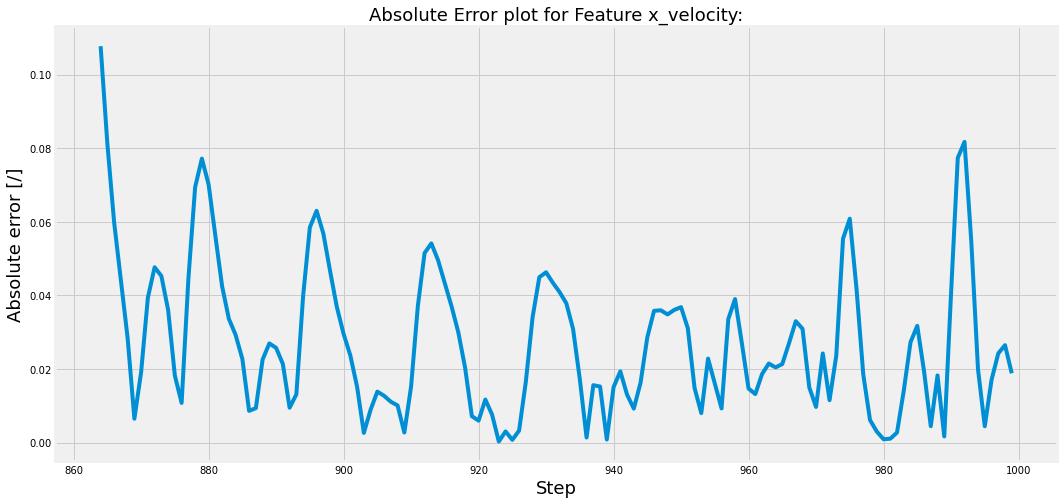

4


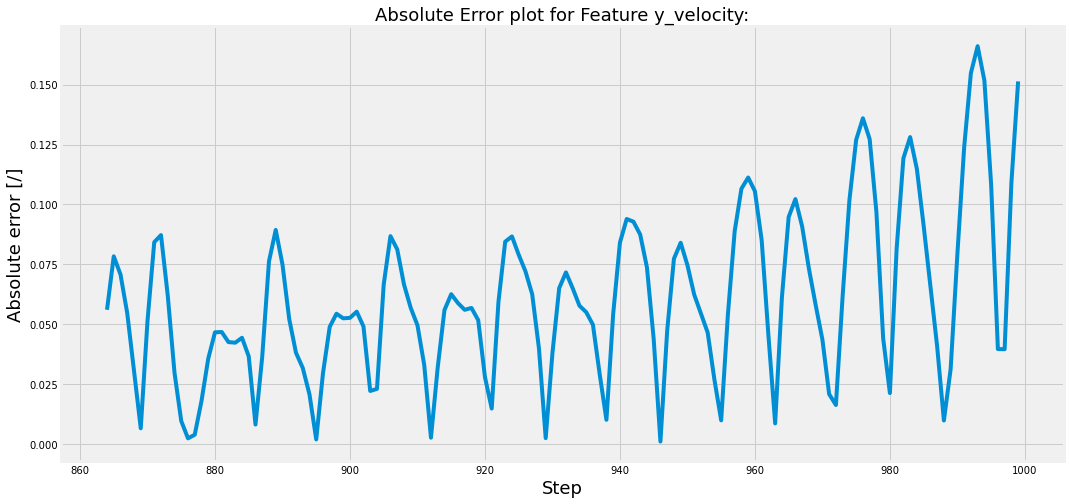

5


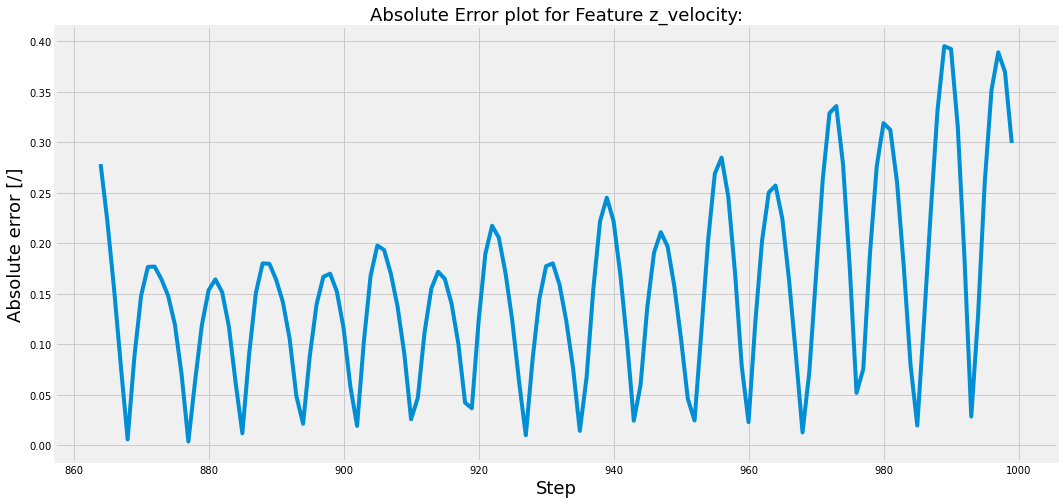

In [22]:
for i in range(0,6):
    print(i)
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    dff['Error']=abs(dff.predictions-dff.testY)/max(dff.testY) # the normalization ct is taken as max of dataset
    plt.figure(figsize=(16,8))
    plt.title(f'Absolute Error plot for Feature {dictt[i]}:', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Absolute error [/]', fontsize=18)
    plt.plot(list(range(864,1000)), dff.Error)
    plt.show()

In [23]:
# AVG ABSOLUTE ERRORS:

print('Mean Absolute Errors:')
print()

for i in range(0,6):
    print('Feature '+str(dictt[i]))
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    dff['Error']=abs(dff.predictions-dff.testY)/max(dff.testY) # the normalization ct is taken as max of dataset
    print(dff.Error.mean())

Mean Absolute Errors:

Feature x
0.034603275974776075
Feature y
0.06386888374731571
Feature z
0.1498432799810484
Feature x_velocity
0.027348493526907016
Feature y_velocity
0.060684661578360825
Feature z_velocity
0.15468271536401706


### 2. Relative errors:

0


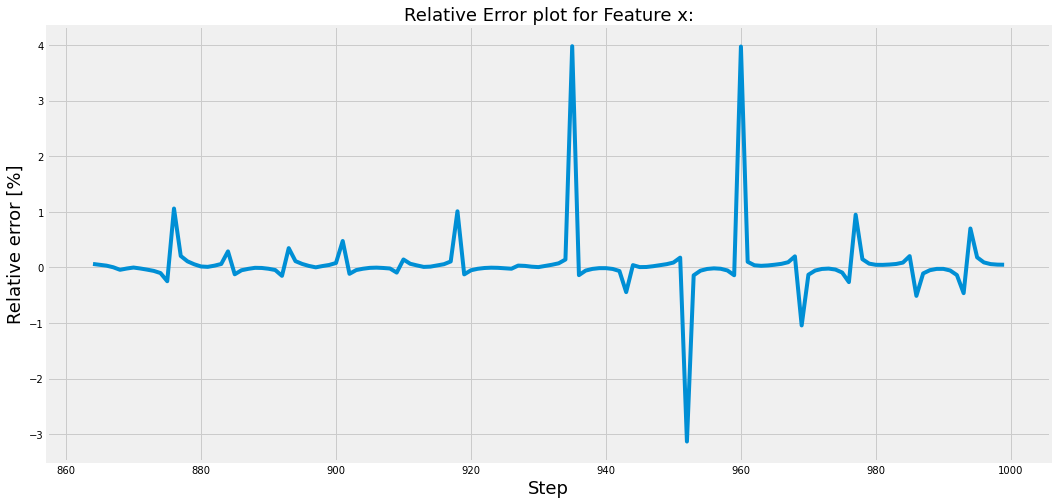

1


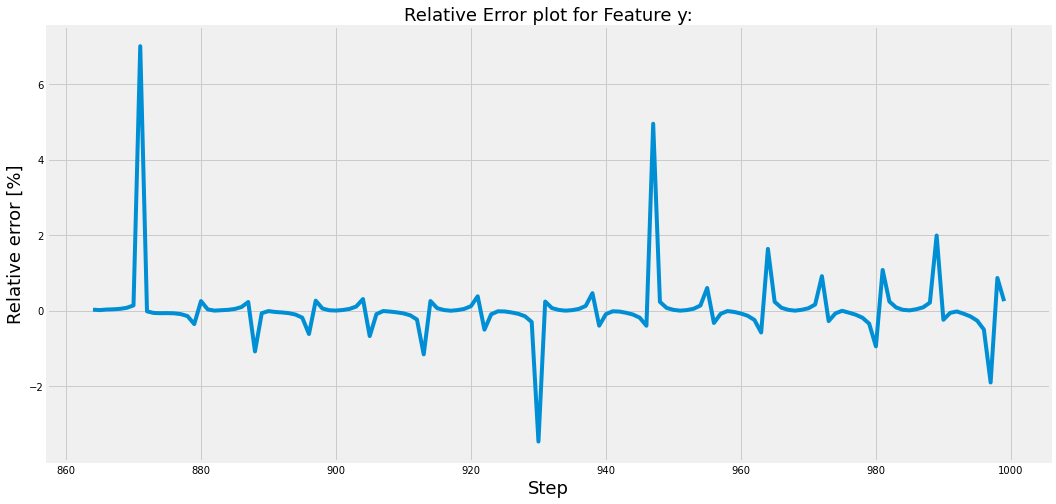

2


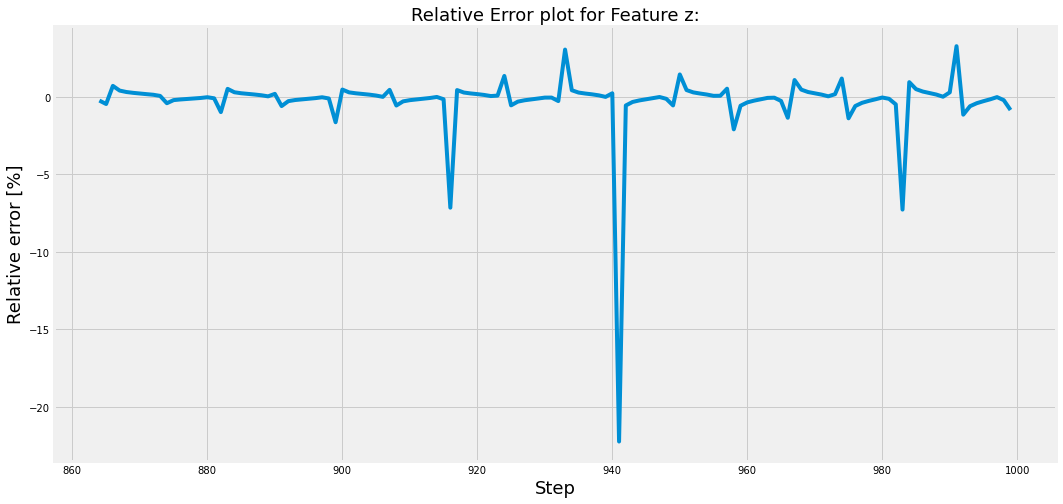

3


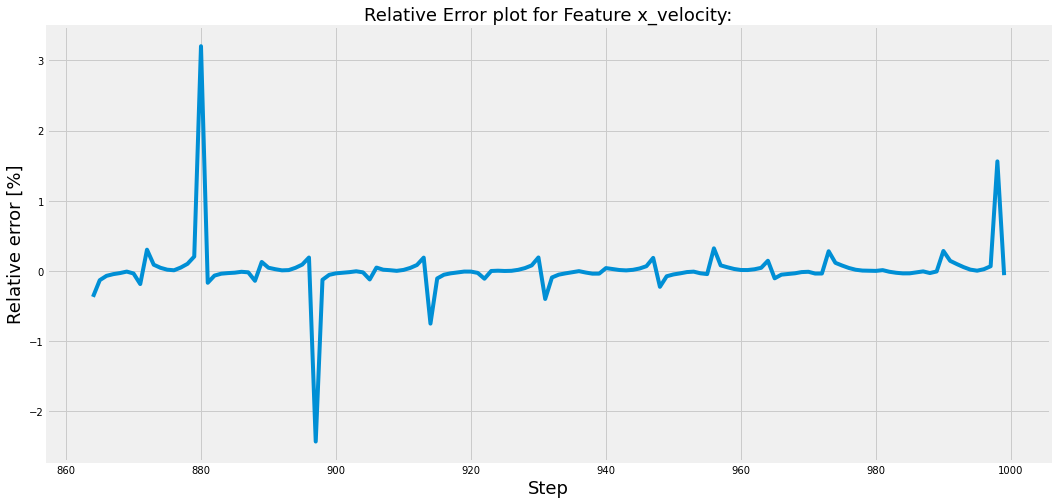

4


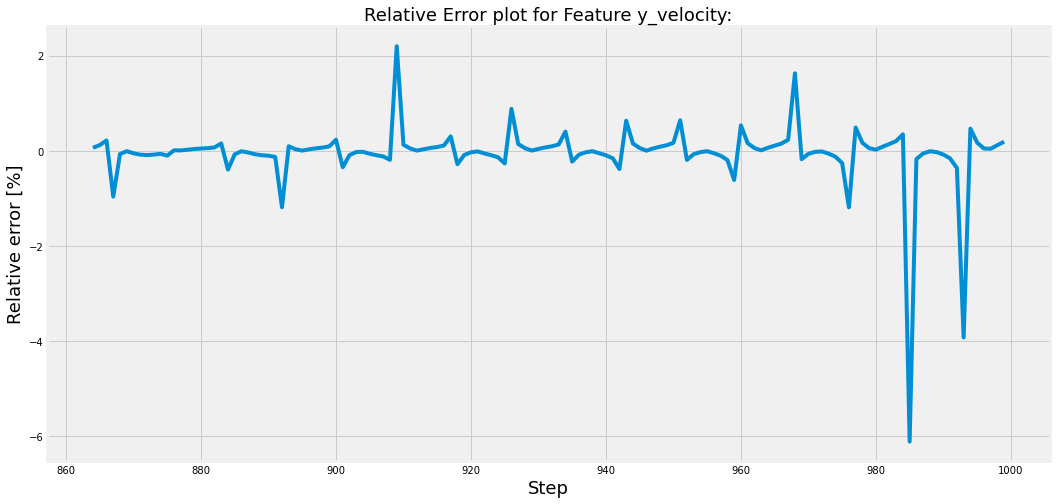

5


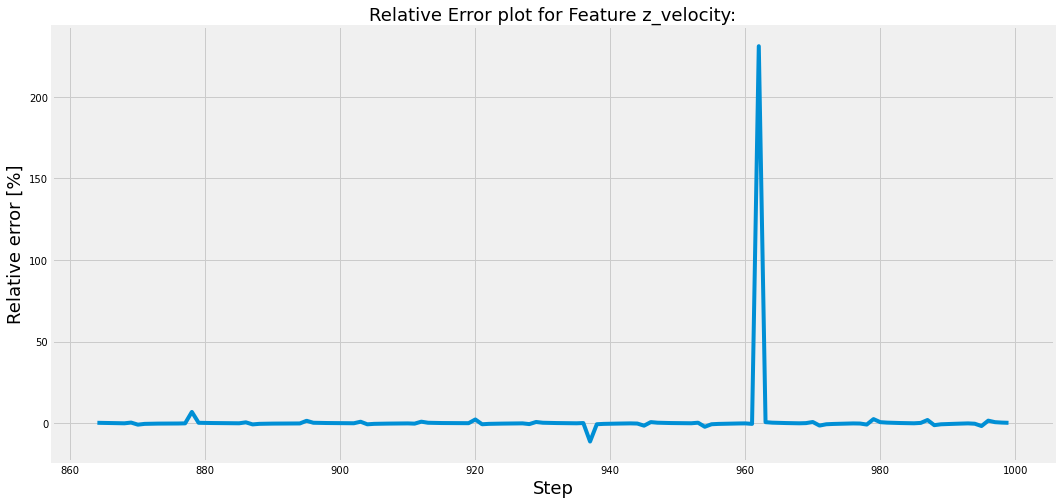

In [24]:
for i in range(0,6):
    print(i)
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    dff['Error']=abs(dff.predictions-dff.testY)/dff.testY # the normalization ct is taken as ISS semi-major axis
    plt.figure(figsize=(16,8))
    plt.title(f'Relative Error plot for Feature {dictt[i]}:', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Relative error [%]', fontsize=18)
    plt.plot(list(range(864,1000)), dff.Error)
    plt.show()

In [25]:
# AVG RELATIVE ERRORS:

print('Mean Relative Errors:')
print()

for i in range(0,6):
    print('Feature '+str(dictt[i]))
    dataa = {'testY': y_test[0,:,i], 'predictions': pred[0,:,i]}
    dff = pd.DataFrame.from_dict(dataa)
    
    dff['Error']=abs(dff.predictions-dff.testY)/dff.testY * 100
    print(dff.Error.mean())

Mean Relative Errors:

Feature x
5.822399229057328
Feature y
5.056017866151075
Feature z
-25.121956724491522
Feature x_velocity
1.7031780129028629
Feature y_velocity
-5.2902795738645585
Feature z_velocity
170.43462131221887


### 3. 3D Plots

Distance 3D:

In [26]:
df_pred=pd.DataFrame(columns=['x','y','z'])
test_df=pd.DataFrame(columns=['x','y','z'])

df_pred['x'] = pred[0,:,0]
df_pred['y'] = pred[0,:,1]
df_pred['z'] = pred[0,:,2]

test_df['x'] = y_test[0,:,0]
test_df['y'] = y_test[0,:,1]
test_df['z'] = y_test[0,:,2]

<Figure size 432x288 with 0 Axes>

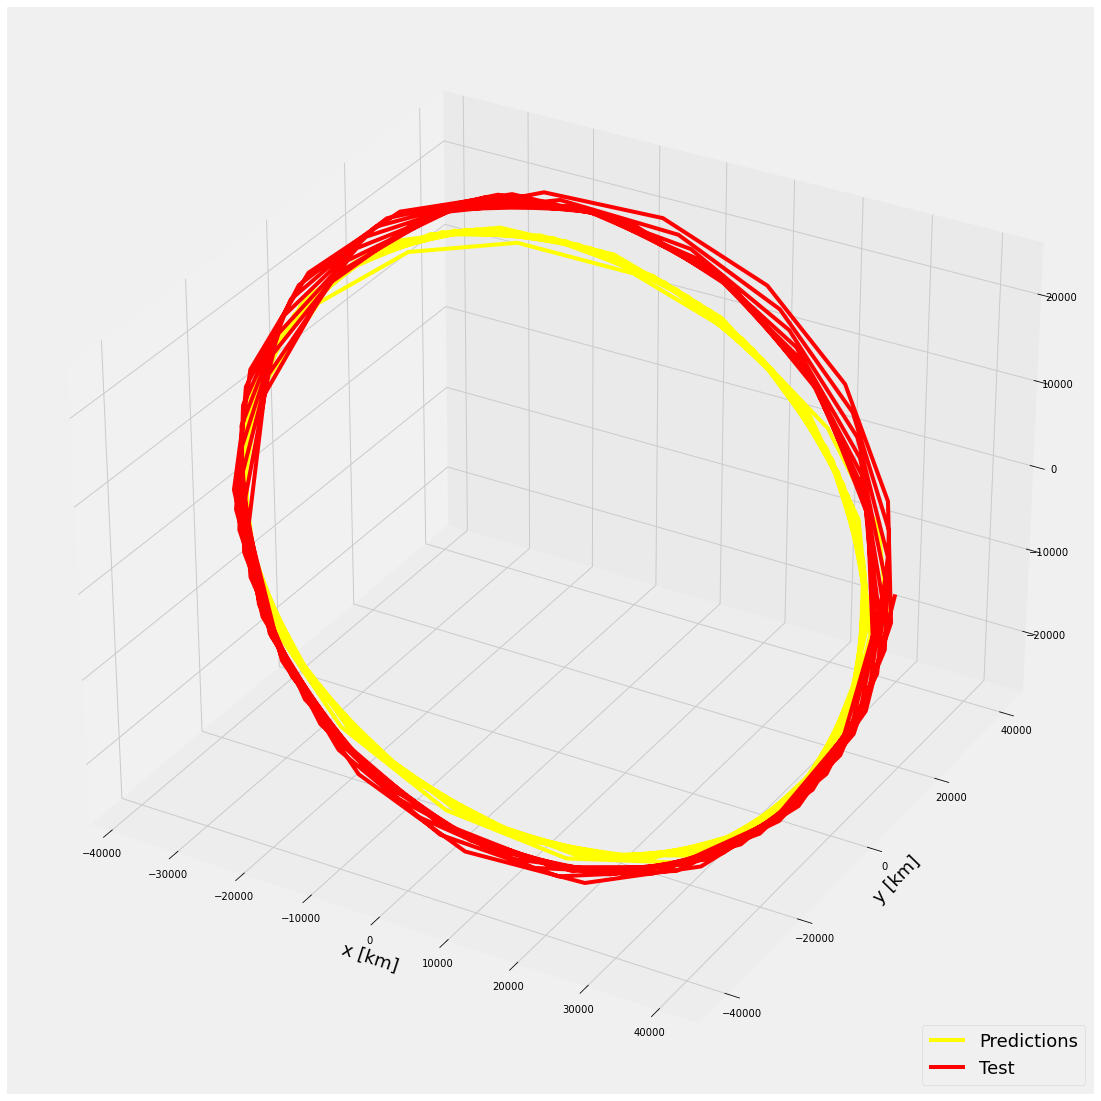

In [32]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'yellow')

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'red')

#plt.title('Predicted vs. Test Orbit 3D Propagation', fontsize=18)
plt.xlabel('x [km]', fontsize=18)
plt.ylabel('y [km]', fontsize=18)
#plt.zlabel('z [m]', fontsize=18)
plt.legend(['Predictions', 'Test'], loc='lower right', fontsize=18)
plt.show()

Velocities 3D:

In [ ]:
df_pred=pd.DataFrame(columns=['x_vv','y_vv','z_vv'])
test_df=pd.DataFrame(columns=['x_vv','y_vv','z_vv'])

df_pred['x_vv'] = pred[0,:,3]
df_pred['y_vv'] = pred[0,:,4]
df_pred['z_vv'] = pred[0,:,5]

test_df['x_vv'] = y_test[0,:,3]
test_df['y_vv'] = y_test[0,:,4]
test_df['z_vv'] = y_test[0,:,5]

In [ ]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x_vv']
y_line = df_pred['y_vv']
z_line = df_pred['z_vv']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x_vv']
y_line2 = test_df['y_vv']
z_line2 = test_df['z_vv']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.xlabel('x [km]', fontsize=18)
plt.ylabel('y [km]', fontsize=18)
plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

### 4. 3D Distance error:

In [28]:
%%time
df_pred=pd.DataFrame(columns=['x','y','z'])
test_df=pd.DataFrame(columns=['x','y','z'])

df_pred['x'] = pred[0,:,0]
df_pred['y'] = pred[0,:,1]
df_pred['z'] = pred[0,:,2]

test_df['x'] = y_test[0,:,0]
test_df['y'] = y_test[0,:,1]
test_df['z'] = y_test[0,:,2]

Wall time: 5.98 ms


In [29]:
# Init empty DF for errors
df_err= pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_err['x_test']=test_df['x']
df_err['y_test']=test_df['y']
df_err['z_test']=test_df['z']

df_err['x_pred']=df_pred['x']
df_err['y_pred']=df_pred['y']
df_err['z_pred']=df_pred['z']

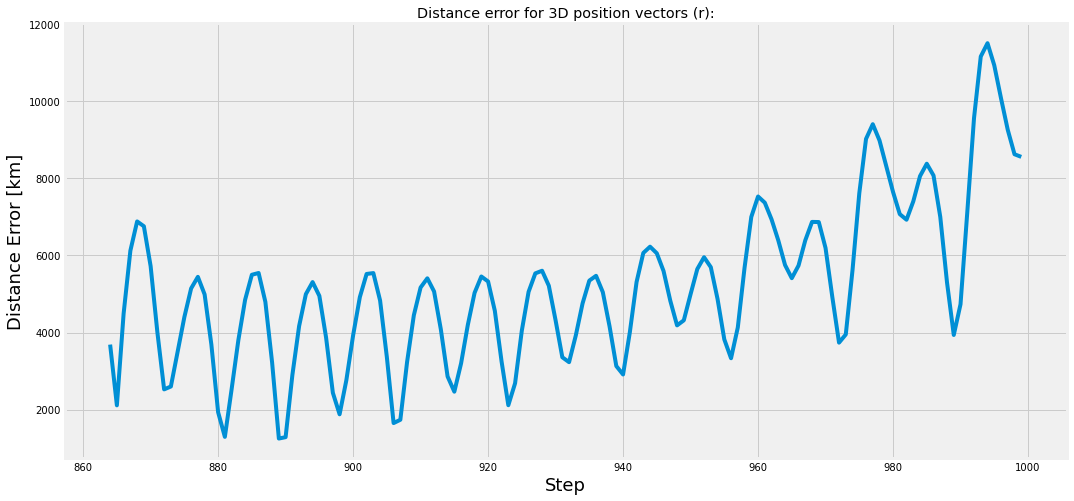

In [30]:
# Difference in distance in 3D (Position)

df_err['distance_error'] = ( (df_err.x_test-df_err.x_pred)**2 + (df_err.y_test-df_err.y_pred)**2 + (df_err.z_test-df_err.z_pred)**2 )**(1/2)
df_err['distance_error'].apply(lambda x: float(x))

# 3D Distance difference plot vs time-stamp
plt.figure(figsize=(16,8))
plt.plot(list(range(864,1000)), df_err.distance_error)
plt.title('Distance error for 3D position vectors (r):')
plt.xlabel('Step', fontsize=18)
plt.ylabel('Distance Error [km]', fontsize=18)
plt.show()